In [1]:
import numpy as np
import cv2
from PIL import Image
import time

In [25]:
#グラフィカルモデルのパラメーター
alpha = -0.7#-0.7
beta = -0.7#-0.7が最適っぽい

#メッセージの収束閾値
epsilon = 0.0001

#元画像
image = cv2.imread("babel.jpg", 0)

#元画像のサイズ
rows = image.shape[0]
columns = image.shape[1]

In [26]:
def get_mask_pixels(mask_image):
    mask_pixels = []
    is_masked = np.zeros((rows, columns))
    for i in range(rows-1):
        for j in range(columns-1):
            if mask_image[i][j]!=255:
                mask_pixels.append([i, j])
                is_masked[i][j]=1
    return mask_pixels, is_masked

In [27]:
def get_boundary(mask_pixels, mask_image):
    boundary=[]
    is_boundary=np.zeros((rows, columns))
    for x in mask_pixels:
        if np.max([mask_image[x[0]+1][x[1]], mask_image[x[0]][x[1]+1], mask_image[x[0]-1][x[1]], mask_image[x[0]][x[1]-1]])==255:
            boundary.append(x)
            is_boundary[x[0]][x[1]]=1
    
    return boundary, is_boundary

In [28]:
def get_edges(mask_pixels, is_masked):
    edges=[]
    for x in mask_pixels:
        for dire in [[1, 0], [-1, 0], [0, 1], [0, -1]]:
            if is_masked[x[0]+dire[0]][x[1]+dire[1]]==1:
                edges.append([x[0], x[1], x[0]+dire[0], x[1]+dire[1]])
    
    return edges

In [29]:
def get_convolution_vector(beta):
    convolution_vector = np.array([np.exp(beta*i**2) for i in range(256)])
    
    return np.fft.fft(convolution_vector)
    #return convolution_vector

In [30]:
def get_mean(boundary, is_masked, masked_image):
    z=np.zeros(len(boundary))
    
    for i in range(len(boundary)):
        row = boundary[i][0]
        column = boundary[i][1]
        adjacent_pixels = 0
        for dire in [[1, 0], [0, -1], [0, 1], [-1, 0]]:
            if is_masked[row+dire[0]][column+dire[1]]==0:
                adjacent_pixels = adjacent_pixels + 1
                z[i]+=masked_image[row+dire[0]][column+dire[1]]
        z[i] = z[i]/adjacent_pixels
        
    return z

In [31]:
def initialize_messages(edges):
    messages = np.random.uniform(0, 1, (len(edges), 256))
    #for i in range(len(edges)):
     #   messages[i] = messages[i]/np.sum(messages[i])
    #messages = np.ones((len(edges), 256))/256
    messages = messages/np.sum(messages, axis=-1).reshape((len(edges), 1))
    return messages

In [32]:
def collect_messages(messages, edges, is_masked, is_boundary, boundary, weights):
    collected_messages = np.ones((len(edges), 256))
    
    for j in range(len(edges)):
        edge = edges[j]
        row = edge[0]
        column = edge[1]
        
        for dire in [[1, 0], [0, 1], [-1, 0], [0, -1]]:
            if [row+dire[0], column+dire[1]]!=[edge[2], edge[3]] and is_masked[row+dire[0]][column+dire[1]]==1:
                collected_messages[j] = collected_messages[j]*messages[edges.index([row+dire[0], column+dire[1], row, column])]
            if is_boundary[row][column]==1:
                collected_messages[j] = weights[boundary.index([row, column])]*collected_messages[j]
        
    collected_messages = np.fft.fft(collected_messages)
                
    return collected_messages

In [33]:
def weight_vectors(boundary, z):
    weights=np.array([[np.exp(alpha*(j-z[i])**2) for j in range(256)] for i in range(len(boundary))])
        
    return weights

In [34]:
def update_messages(messages, edges, is_masked, is_boundary, boundary, weights, convolution_vector):
    collected_messages = collect_messages(messages, edges, is_masked, is_boundary, boundary, weights)
    updated_messages = np.ones(messages.shape)
    
    updated_messages = np.fft.ifft(collected_messages*convolution_vector)
        #for j in range(256):
         #   updated_messages[i][j] = np.sum([ collected_messages[i][k]*np.exp(beta*(k-j)**2) for k in range(256)])
        
        
        #updated_messages[i] = updated_messages[i]/np.sum(updated_messages[i])
        
    updated_messages = np.abs(updated_messages)
        
    updated_messages = updated_messages/np.sum(updated_messages, axis=-1).reshape((len(edges),1))
        
    return updated_messages

In [35]:
def is_convergent(updated_messages, messages, epsilon):
    total_error = np.sum(np.abs(updated_messages-messages))/len(updated_messages)
    
    if total_error < epsilon:
        print("convergent: total_error = {0}".format(total_error))
        print("\n")
        return True
    else:
        print("disconvergent: total_error = {0}".format(total_error))
        print('\n')
        return False

In [36]:
def calculate_marginal_distributions(messages, mask_pixels, is_masked, edges, is_boundary, boundary, weights):
    marginal_distributions = np.ones((len(mask_pixels), 256))
    
    for i in range(len(mask_pixels)):
        row = mask_pixels[i][0]
        column = mask_pixels[i][1]
        for dire in [[1, 0], [0, 1], [-1, 0], [0, -1]]:
            if is_masked[row+dire[0]][column+dire[1]]==1:
                marginal_distributions[i] = marginal_distributions[i]*messages[edges.index([row+dire[0], column+dire[1], row, column])]
                
        if is_boundary[row][column]==1:
            marginal_distributions[i] = marginal_distributions[i]*weights[boundary.index([row, column])]
            
    return marginal_distributions

In [37]:
def remove_boundary(boundary, mask_image, masked_image, repaired):
    for pixel in boundary:
        mask_image[pixel[0]][pixel[1]] = 255
        masked_image[pixel[0]][pixel[1]] = repaired[pixel[0]][pixel[1]]
        
    return mask_image, masked_image

In [38]:
def repair(masked_image, mask_image, max_iter):
    print("start")
    mask_pixels, is_masked=get_mask_pixels(mask_image)
    boundary, is_boundary=get_boundary(mask_pixels, mask_image)
    
    edges = get_edges(mask_pixels, is_masked)
    messages=initialize_messages(edges)
    z = get_mean(boundary, is_masked, masked_image)
    weights = weight_vectors(boundary, z)
    convolution_vector = get_convolution_vector(beta)
    
    print("{0} edges".format(len(edges)))
    print("{0} pixels are masked.".format(len(mask_pixels)))
    print("boundary pixels: {0}".format(len(boundary)))
    iterations = 0
    print("iteration starts")
    start = time.time()
    updated_messages = update_messages(messages, edges, is_masked, is_boundary, boundary, weights, convolution_vector)
    iterations+=1
    t = time.time()-start
    print("iteration: {0}".format(iterations))
    print("elsped time: {0}".format(t))
    
    while not is_convergent(messages, updated_messages, epsilon):
        messages = updated_messages
        updated_messages = update_messages(messages, edges, is_masked, is_boundary, boundary, weights, convolution_vector)
        t = time.time()-start
        iterations+=1
        print("iteration: {0}".format(iterations))
        print("elsped time: {0}".format(t))
        max_iter-=1
        
        if max_iter==1:
            is_convergent(messages, updated_messages, epsilon)
            print("reached max_iter")
            break
            
    
    repaired = masked_image
    md=calculate_marginal_distributions(messages, mask_pixels, is_masked, edges, is_boundary, boundary, weights)
    for i in range(len(mask_pixels)):
        value = np.argmax(md[i])
        repaired[mask_pixels[i][0]][mask_pixels[i][1]] = value
    Image.fromarray(repaired.astype(np.uint8), mode="L")
    
    return repaired, updated_messages, messages

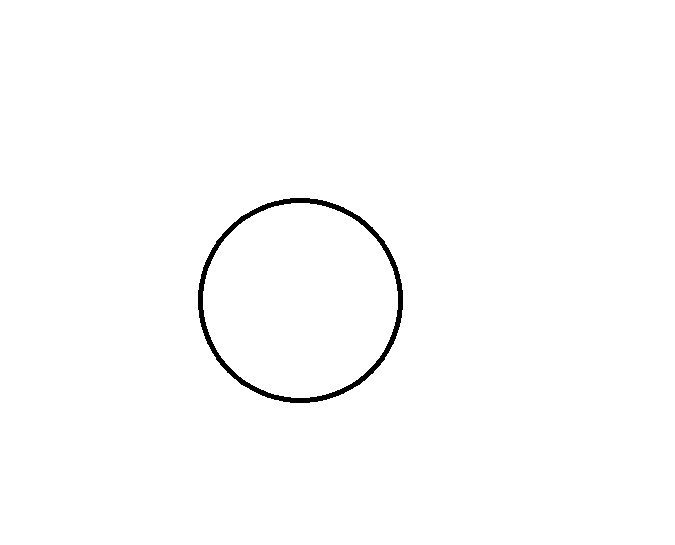

In [39]:

mask_image=255*np.ones((rows, columns), dtype=np.uint8)
mask_image = cv2.circle(mask_image, (300, 300), 100, 0, 3)

#mask_image = cv2.rectangle(mask_image,(384,10),(510,128), 0, 3)

#for i in range(rows):
 #   for j in range(columns):
  #      if mask_image[i][j]==0:
   #         mask_image[i][j] = 255
    #    else:
     #       mask_image[i][j] = 0

mask_pixels, is_masked=get_mask_pixels(mask_image)
Image.fromarray(mask_image.astype(np.uint8), mode='L')

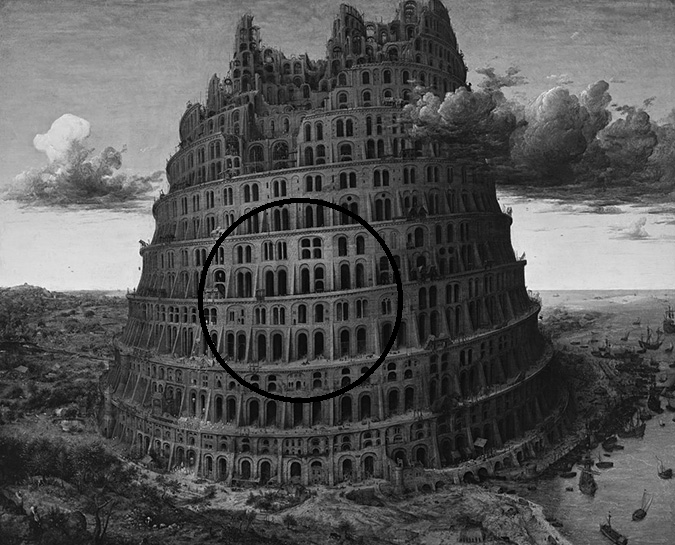

In [40]:
masked_image = image.copy()
masked_image= cv2.circle(masked_image, (300, 300), 100, 0, 3)

#masked_image = cv2.rectangle(image,(384,10),(510,128), 0, 3)

#masked_image=np.zeros((rows,columns))
#for i in range(rows):
 #   for j in range(columns):
  #      if is_masked[i][j]==1:
   #         masked_image[i][j]=mask_image[i][j]
    #    else:
     #       masked_image[i][j]=image[i][j]
    
masked_image=masked_image.astype(np.uint8)
Image.fromarray(masked_image, mode="L")

start
10976 edges
3144 pixels are masked.
boundary pixels: 1131
iteration starts
iteration: 1
elsped time: 7.366883993148804
disconvergent: total_error = 1.1033622041618794


iteration: 2
elsped time: 16.01485562324524
disconvergent: total_error = 1.2243134462402432


iteration: 3
elsped time: 23.513094663619995
disconvergent: total_error = 1.2022712363679293


iteration: 4
elsped time: 30.77339482307434
disconvergent: total_error = 1.0435499789096119


iteration: 5
elsped time: 38.92196178436279
disconvergent: total_error = 1.0427270836559717


reached max_iter


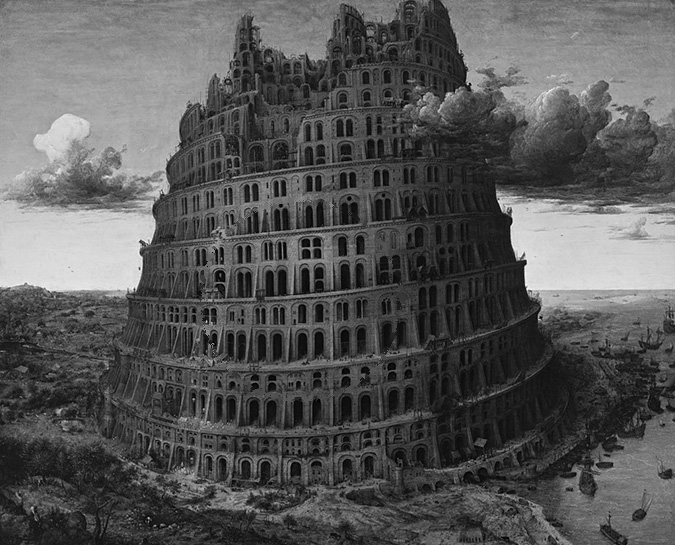

In [41]:
repaired, updated_messages, messages=repair(masked_image, mask_image, 5)
Image.fromarray(repaired)

In [42]:
np.mean((repaired-image)**2)

0.6918491335372069

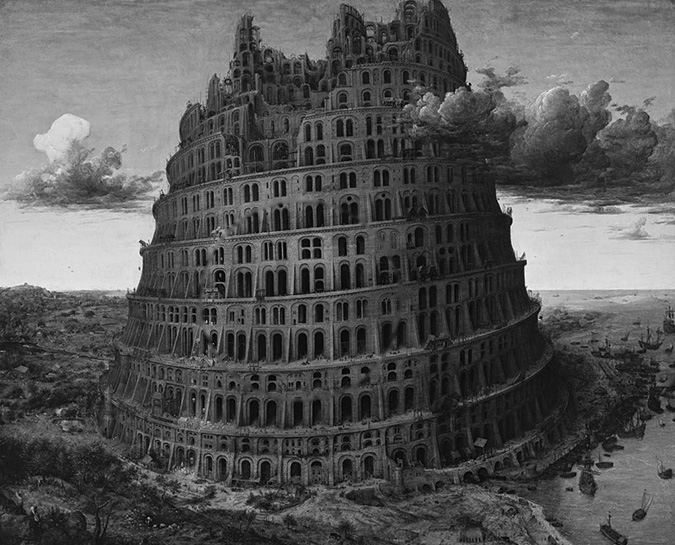

In [23]:
#別のアルゴリズムと比較
import cv2

#img = cv2.imread('messi_2.jpg')
#mask = cv2.imread('mask2.png',0)
mask_image2 = np.zeros((rows, columns), dtype=np.uint8)

for i in range(rows):
    for j in range(columns):
        if is_masked[i][j]==1:
            mask_image2[i][j]=255
mask_image2.astype(np.uint8)

dst = cv2.inpaint(masked_image,mask_image2,3,cv2.INPAINT_TELEA)
Image.fromarray(dst)

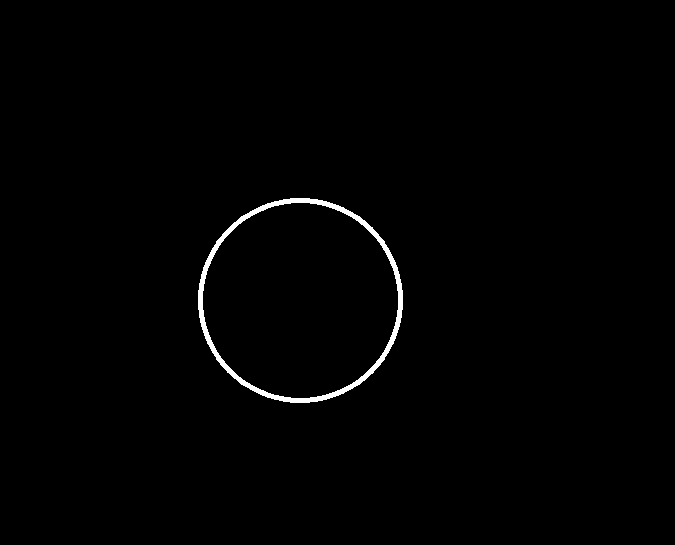

In [22]:
Image.fromarray(mask_image2.astype(np.uint8), mode='L')

In [24]:
np.mean((dst-image)**2)

0.7172816853550799